In [ ]:
# # Split into train/val/test
# from sklearn.model_selection import train_test_split

# X = df.drop(columns=['timestamp'], errors='ignore')
# y = df['high_energy'] if 'high_energy' in df.columns else np.random.randint(0, 2, size=len(df))

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Recursive Feature Elimination
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFECV

# base_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rfe = RFECV(estimator=base_model, step=1, cv=3, scoring='f1')
# rfe.fit(X_train.fillna(0), y_train)

# X_train_sel = X_train.loc[:, rfe.support_]
# X_val_sel = X_val.loc[:, rfe.support_]
# X_test_sel = X_test.loc[:, rfe.support_]

# logger.info(f"Selected {X_train_sel.shape[1]} features using RFE.")

# # Hyperparameter tuning + model training
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, None],
#     'min_samples_split': [2, 5]
# }

# grid_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
# grid_model.fit(X_train_sel.fillna(0), y_train)

# best_model = grid_model.best_estimator_
# logger.info(f"Best model: {best_model}")

# # Evaluate on test set


# def evaluate_model(model, X, y_true):
#     y_pred = model.predict(X)
#     y_proba = model.predict_proba(X)[:, 1]
#     return {
#         'accuracy': accuracy_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred),
#         'recall': recall_score(y_true, y_pred),
#         'f1': f1_score(y_true, y_pred),
#         'auc': roc_auc_score(y_true, y_proba)
#     }

# test_scores = evaluate_model(best_model, X_test_sel.fillna(0), y_test)

# logger.info("Test Set Evaluation Scores:")
# for k, v in test_scores.items():
#     logger.info(f"{k.upper()}: {v:.4f}")

# # Insight: Top features
# top_features = pd.Series(best_model.feature_importances_, index=X_train_sel.columns).sort_values(ascending=False)
# logger.info("Top 10 Features in Final Model:")
# logger.info(top_features.head(10))

# # Visualize Confusion Matrix and ROC Curve
# from sklearn.metrics import confusion_matrix, roc_curve
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Confusion Matrix
# conf_mat = confusion_matrix(y_test, best_model.predict(X_test_sel.fillna(0)))
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.tight_layout()
# plt.show()

# # ROC Curve
# y_scores = best_model.predict_proba(X_test_sel.fillna(0))[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_scores)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"AUC = {test_scores['auc']:.2f}", color='#7CD9A5')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Log results to HTML report
# import sweetviz as sv
# report = sv.analyze(pd.concat([X_test_sel, y_test.reset_index(drop=True)], axis=1))
# report.show_html("model_eval_report.html")
# logger.info("Sweetviz report written to model_eval_report.html")

# # Run sequence model (LSTM)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler

# # Prepare sequence data (e.g., use a single feature for demo)
# sequence_feature = 'energy_output_btu'
# if sequence_feature in df.columns:
#     seq_data = df[[sequence_feature]].fillna(method='ffill').values
#     scaler = MinMaxScaler()
#     scaled_seq = scaler.fit_transform(seq_data)

#     def create_sequences(data, seq_len):
#         X, y = [], []
#         for i in range(len(data) - seq_len):
#             X.append(data[i:i+seq_len])
#             y.append(data[i+seq_len])
#         return np.array(X), np.array(y)

#     X_seq, y_seq = create_sequences(scaled_seq, seq_len=10)

#     model = Sequential([
#         Input(shape=(X_seq.shape[1], X_seq.shape[2])),
#         LSTM(64, return_sequences=False),
#         Dropout(0.2),
#         Dense(1)
#     ])
#     model.compile(optimizer=Adam(0.001), loss='mse')
#     model.fit(X_seq, y_seq, epochs=10, batch_size=32, verbose=0)
#     logger.info("LSTM sequence model trained for demo.")

# # Isolation Forest Anomaly Detection (sklearn)
# from sklearn.ensemble import IsolationForest
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# anomaly_feature = 'vl_comp_suction_pressure'
# if anomaly_feature in df.columns:
#     anomaly_df = df[[anomaly_feature]].fillna(method='ffill').dropna()
#     scaler = StandardScaler()
#     scaled_series = scaler.fit_transform(anomaly_df)

#     iso_forest = IsolationForest(contamination=0.05, random_state=42)
#     labels = iso_forest.fit_predict(scaled_series)
#     anomaly_df['anomaly'] = labels

#     plt.figure(figsize=(10, 5))
#     plt.plot(anomaly_df[anomaly_feature].values, label=anomaly_feature, color='#7CD9A5')
#     plt.scatter(anomaly_df.index[anomaly_df['anomaly'] == -1], 
#                 anomaly_df.loc[anomaly_df['anomaly'] == -1, anomaly_feature],
#                 color='red', marker='x', label='Anomaly')
#     plt.title(f"IsolationForest Anomaly Detection on {anomaly_feature}")
#     plt.xlabel("Index")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     logger.info(f"IsolationForest detected {(labels == -1).sum()} anomalies in {anomaly_feature}.")
# # Automated anomaly detection for multiple features
# anomaly_features = [
#     'bge_h2soutlet_temp', 'vl_comp_suction_temp', 'vl_comp_suction_pressure',
#     'bge_blowersuction_temp', 'bge_blowersuction_pressure',
#     'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2'
# ]

# anomaly_results = {}
# all_anomalies = pd.DataFrame()

# for feature in anomaly_features:
#     if feature in df.columns:
#         series = df[[feature]].fillna(method='ffill').dropna()
#         scaled = StandardScaler().fit_transform(series)
#         model = IsolationForest(contamination=0.05, random_state=42)
#         labels = model.fit_predict(scaled)

#         df_anomalies = series.copy()
#         df_anomalies['anomaly'] = labels
#         df_anomalies['feature'] = feature
#         all_anomalies = pd.concat([all_anomalies, df_anomalies[df_anomalies['anomaly'] == -1]])

#         anomaly_results[feature] = int((labels == -1).sum())
#         logger.info(f"Detected {anomaly_results[feature]} anomalies in {feature}.")

# # Save anomaly report
# anomaly_report_path = "anomaly_report.csv"
# all_anomalies.to_csv(anomaly_report_path)
# logger.info(f"Anomaly report saved to {anomaly_report_path}")

# # Plot anomalies from saved report with time filtering
# import pandas as pd
# import matplotlib.pyplot as plt

# try:
#     anomaly_data = pd.read_csv("anomaly_report.csv")
#     if 'timestamp' in df.columns:
#         df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#         anomaly_data = anomaly_data.merge(df[['timestamp']], left_index=True, right_index=True, how='left')

#         # Filter by recent time window (last 30 days if available)
#         latest_ts = anomaly_data['timestamp'].max()
#         if pd.notnull(latest_ts):
#             time_window = latest_ts - pd.Timedelta(days=30)
#             recent_anomalies = anomaly_data[anomaly_data['timestamp'] >= time_window]
#         else:
#             recent_anomalies = anomaly_data.copy()
#     else:
#         recent_anomalies = anomaly_data.copy()

#     # Plot each feature's anomalies
#     features = recent_anomalies['feature'].unique()
#     for feature in features:
#         sub = recent_anomalies[recent_anomalies['feature'] == feature]
#         plt.figure(figsize=(10, 4))
#         plt.scatter(sub['timestamp'] if 'timestamp' in sub else sub.index, sub[feature], color='red', marker='x', label='Anomaly')
#         plt.title(f"Recent Anomalies in {feature}")
#         plt.xlabel("Time" if 'timestamp' in sub else "Index")
#         plt.ylabel(feature)
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

# except Exception as e:
#     logger.warning(f"Could not load or plot anomaly report: {e}")

# # Write back to S3
# wr.s3.to_csv(df, path=s3_output, index=False)
# logger.info(f"Feature-engineered dataset written to: {s3_output}")

2025-04-10 01:52:25.119947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 01:52:27,750 - INFO - Reading dataset from: s3://sagemaker-us-east-2-426179662034/canvas/processed/facility_feature_engineered.csv
2025-04-10 01:52:27,822 - INFO - Initializing a Ray instance
2025-04-10 01:52:29,141	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 904900608 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.85gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to 

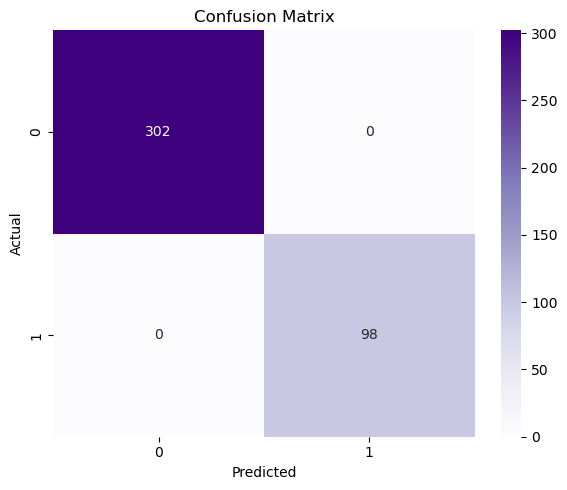

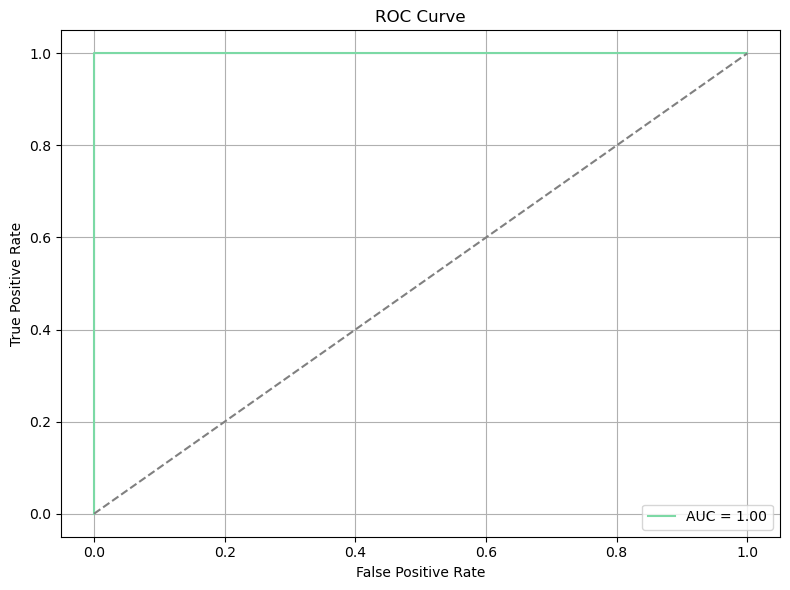

/tmp/ipykernel_26733/3494835752.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seq_data = df[[sequence_feature]].fillna(method='ffill').values
2025-04-10 01:56:02,123 - INFO - LSTM sequence model trained for demo.
/tmp/ipykernel_26733/3494835752.py:160: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  anomaly_df = df[[anomaly_feature]].fillna(method='ffill').dropna()


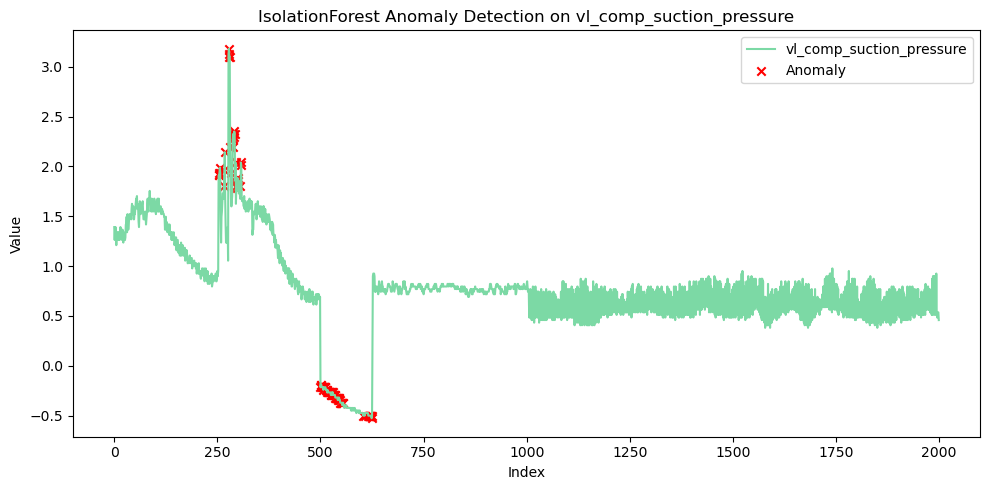

2025-04-10 01:56:02,497 - INFO - IsolationForest detected 97 anomalies in vl_comp_suction_pressure.
2025-04-10 01:56:02,673 - INFO - Detected 100 anomalies in bge_h2soutlet_temp.
2025-04-10 01:56:02,864 - INFO - Detected 100 anomalies in vl_comp_suction_temp.
2025-04-10 01:56:03,038 - INFO - Detected 97 anomalies in vl_comp_suction_pressure.
2025-04-10 01:56:03,216 - INFO - Detected 100 anomalies in bge_blowersuction_temp.
2025-04-10 01:56:03,393 - INFO - Detected 99 anomalies in bge_blowersuction_pressure.
2025-04-10 01:56:03,545 - INFO - Detected 6 anomalies in abb_gc_outletstream_h2s.
2025-04-10 01:56:03,718 - INFO - Detected 98 anomalies in abb_gc_outletstream_co2.
2025-04-10 01:56:03,860 - INFO - Anomaly report saved to s3://sagemaker-us-east-2-426179662034/canvas/processed/anomaly_report.csv
2025-04-10 01:56:03,862 - INFO - Reading dataset from: s3://sagemaker-us-east-2-426179662034/canvas/processed/anomaly_report.csv


#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$#@$
['abb_gc_outletstream_h2s' 'abb_gc_outletstream_co2']


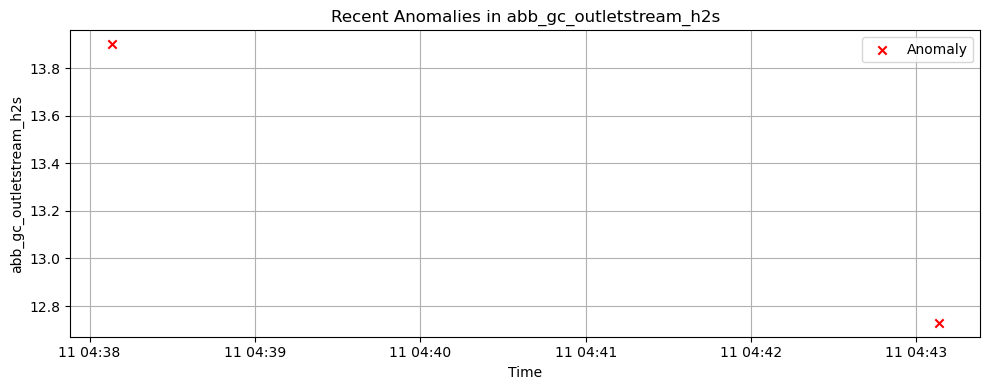

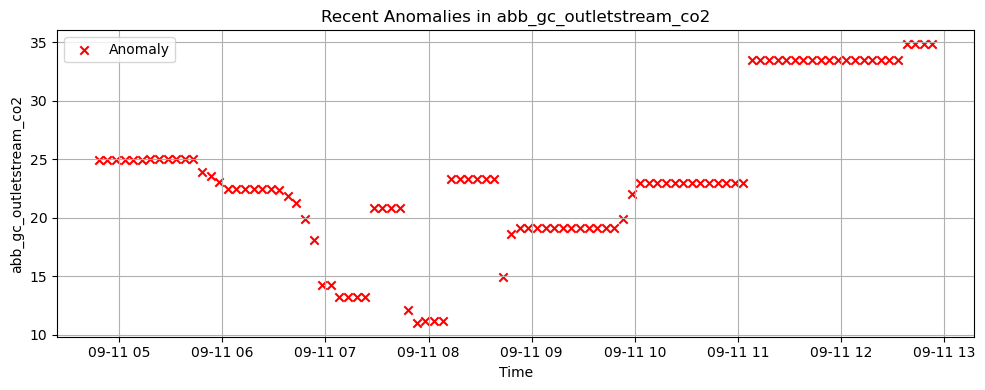

2025-04-10 01:56:05,075 - INFO - Feature-engineered dataset written to: s3://sagemaker-us-east-2-426179662034/canvas/processed/facility_model_developed.csv


In [1]:
# Required imports
import pandas as pd
import numpy as np
import awswrangler as wr
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

# Set up logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# 🔁 S3 reader function
def read_data_from_s3(s3_path):
    logger.info(f"Reading dataset from: {s3_path}")
    df = wr.s3.read_csv(s3_path)

    # Deduplicate columns
    if df.columns.duplicated().any():
        logger.warning("Duplicate column names detected. Renaming them to ensure uniqueness.")
        df.columns = pd.io.parsers.ParserBase({'names': df.columns})._maybe_dedup_names(df.columns)

    return df


# Evaluate on test set
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'auc': roc_auc_score(y_true, y_proba)
        }


def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)


# 🔧 Main pipeline
def main():
    s3_input = 's3://sagemaker-us-east-2-426179662034/canvas/processed/facility_feature_engineered.csv'
    s3_output = 's3://sagemaker-us-east-2-426179662034/canvas/processed/facility_model_developed.csv'

    df = read_data_from_s3(s3_input)

    # Split into train/val/test
    X = df.drop(columns=['timestamp'], errors='ignore')
    y = df['high_energy'] if 'high_energy' in df.columns else np.random.randint(0, 2, size=len(df))

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Recursive Feature Elimination
    base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFECV(estimator=base_model, step=1, cv=3, scoring='f1')
    rfe.fit(X_train.fillna(0), y_train)

    X_train_sel = X_train.loc[:, rfe.support_]
    X_val_sel = X_val.loc[:, rfe.support_]
    X_test_sel = X_test.loc[:, rfe.support_]

    logger.info(f"Selected {X_train_sel.shape[1]} features using RFE.")

    # Hyperparameter tuning + model training
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }

    grid_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
    grid_model.fit(X_train_sel.fillna(0), y_train)

    best_model = grid_model.best_estimator_
    logger.info(f"Best model: {best_model}")

    test_scores = evaluate_model(best_model, X_test_sel.fillna(0), y_test)

    logger.info("Test Set Evaluation Scores:")
    for k, v in test_scores.items():
        logger.info(f"{k.upper()}: {v:.4f}")

    # Insight: Top features
    top_features = pd.Series(best_model.feature_importances_, index=X_train_sel.columns).sort_values(ascending=False)
    logger.info("Top 10 Features in Final Model:")
    logger.info(top_features.head(10))

    # Visualize Confusion Matrix and ROC Curve
    conf_mat = confusion_matrix(y_test, best_model.predict(X_test_sel.fillna(0)))
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    y_scores = best_model.predict_proba(X_test_sel.fillna(0))[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {test_scores['auc']:.2f}", color='#7CD9A5')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # test_df = pd.concat([X_test_sel, y_test.reset_index(drop=True)], axis=1)

    # # Check for duplicates and resolve them
    # if df.columns.duplicated().any():
    #     logger.warning("Duplicate column names detected after concatenation. Renaming them to ensure uniqueness.")
    #     test_df.columns = pd.io.parsers.ParserBase({'names': test_df.columns})._maybe_dedup_names(test_df.columns)

    # report = sv.analyze(test_df)
    # report.show_html("model_eval_report.html")
    # logger.info("Sweetviz report written to model_eval_report.html")

    sequence_feature = 'energy_output_btu'
    if sequence_feature in df.columns:
        seq_data = df[[sequence_feature]].fillna(method='ffill').values
        scaler = MinMaxScaler()
        scaled_seq = scaler.fit_transform(seq_data)
        X_seq, y_seq = create_sequences(scaled_seq, seq_len=10)
        model = Sequential([
            Input(shape=(X_seq.shape[1], X_seq.shape[2])),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.001), loss='mse')
        model.fit(X_seq, y_seq, epochs=10, batch_size=32, verbose=0)
        logger.info("LSTM sequence model trained for demo.")

    # Anamoly detection
    anomaly_feature = 'vl_comp_suction_pressure'
    if anomaly_feature in df.columns:
        anomaly_df = df[[anomaly_feature]].fillna(method='ffill').dropna()
        scaler = StandardScaler()
        scaled_series = scaler.fit_transform(anomaly_df)

        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        labels = iso_forest.fit_predict(scaled_series)
        anomaly_df['anomaly'] = labels

        plt.figure(figsize=(10, 5))
        plt.plot(anomaly_df[anomaly_feature].values, label=anomaly_feature, color='#7CD9A5')
        plt.scatter(anomaly_df.index[anomaly_df['anomaly'] == -1], 
                    anomaly_df.loc[anomaly_df['anomaly'] == -1, anomaly_feature],
                    color='red', marker='x', label='Anomaly')
        plt.title(f"IsolationForest Anomaly Detection on {anomaly_feature}")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

        logger.info(f"IsolationForest detected {(labels == -1).sum()} anomalies in {anomaly_feature}.")

    anomaly_features = [
        'bge_h2soutlet_temp', 'vl_comp_suction_temp', 'vl_comp_suction_pressure',
        'bge_blowersuction_temp', 'bge_blowersuction_pressure',
        'abb_gc_outletstream_h2s', 'abb_gc_outletstream_co2'
    ]

    anomaly_results = {}
    all_anomalies = pd.DataFrame()

    for feature in anomaly_features:
        if feature in df.columns:
            series = df[[feature]].ffill().dropna()
            scaled = StandardScaler().fit_transform(series)
            model = IsolationForest(contamination=0.05, random_state=42)
            labels = model.fit_predict(scaled)

            df_anomalies = series.copy()
            df_anomalies['anomaly'] = labels
            df_anomalies['feature'] = feature
            all_anomalies = pd.concat([all_anomalies, df_anomalies[df_anomalies['anomaly'] == -1]])

            anomaly_results[feature] = int((labels == -1).sum())
            logger.info(f"Detected {anomaly_results[feature]} anomalies in {feature}.")

    anomaly_report_path = 's3://sagemaker-us-east-2-426179662034/canvas/processed/anomaly_report.csv'
    wr.s3.to_csv(all_anomalies, path=anomaly_report_path, index=False)
    logger.info(f"Anomaly report saved to {anomaly_report_path}")

    try:
        anomaly_data = read_data_from_s3(anomaly_report_path)
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
            anomaly_data = anomaly_data.merge(df[['timestamp']], left_index=True, right_index=True, how='left')

            latest_ts = anomaly_data['timestamp'].max()
            if pd.notnull(latest_ts):
                time_window = latest_ts - pd.Timedelta(days=30)
                recent_anomalies = anomaly_data[anomaly_data['timestamp'] >= time_window]
            else:
                recent_anomalies = anomaly_data.copy()
        else:
            recent_anomalies = anomaly_data.copy()

        features = recent_anomalies['feature'].unique()
        print("#@$"*50)
        print(features)
        for feature in features:
            sub = recent_anomalies[recent_anomalies['feature'] == feature]
            plt.figure(figsize=(10, 4))
            plt.scatter(sub['timestamp'] if 'timestamp' in sub else sub.index, sub[feature], color='red', marker='x', label='Anomaly')
            plt.title(f"Recent Anomalies in {feature}")
            plt.xlabel("Time" if 'timestamp' in sub else "Index")
            plt.ylabel(feature)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        logger.warning(f"Could not load or plot anomaly report: {e}")

    # Save final version
    wr.s3.to_csv(df, path=s3_output, index=False)
    logger.info(f"Feature-engineered dataset written to: {s3_output}")


# Entry point
if __name__ == "__main__":
    main()